## EY Datawave Challenge Code

**Simple rule**: 
- all "df_xx" types are pd.DataFrame
- "xx_data" are usually NumPy arrays

# What is in this Version:

Before, we have been predicting by considering all the trajectories separately. Yet, this approach may be misleading in that our goal is to predict **each person's position between 15:00 ~ 16:00 PM, not other time period.** So, it may be better to group trajectories of the same person into one row.

What I used for feature here:

1. Total time elapsed
2. distance from park center (last point)
3. within the park center (last trajectories' entry)
4. within the park center (overall trajectories' exit)
5. Average Velocity
6. Average Bearing (maybe deviation angle from the straight line from starting point to park center?)
7. velocity of last trajectory


In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn import preprocessing, model_selection
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
import math
import tensorflow.keras.preprocessing.sequence as sequence

# pd.set_option('display.max_columns', None)

# Cool point got from here

https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/

In [2]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

# Create a Callback

In [3]:
class MyCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('acc') >= 0.98:
            print("Reached 98% acc so cancelling training!")
            self.model.stop_training = True

reach_90acc = MyCallback()

# Metric for F1

https://medium.com/@thongonary/how-to-compute-f1-score-for-each-epoch-in-keras-a1acd17715a2

In [4]:
class F1(keras.callbacks.Callback):
    def __init__(self, val_data):
        super().__init__()
        self.validation_data = val_data
        
    def on_train_begin(self, logs={}):
        self.val_f1s = []
        self.val_recalls = []
        self.val_precisions = []

    def on_epoch_end(self, epoch, logs={}):
        val_predict = (np.asarray(self.model.predict(self.validation_data[0]))).round()
        val_targ = self.validation_data[1]
        _val_f1 = f1_score(val_targ, val_predict)
        _val_recall = recall_score(val_targ, val_predict)
        _val_precision = precision_score(val_targ, val_predict)
        self.val_f1s.append(_val_f1)
        self.val_recalls.append(_val_recall)
        self.val_precisions.append(_val_precision)
        print ("— val_f1: %f — val_precision: %f — val_recall %f" %(_val_f1, _val_precision, _val_recall))
        return

# Read the Data

df is training data + label

In [5]:
#read training data
raw_train = pd.read_csv("/Users/Godwithus/Desktop/EY/data_train.csv", low_memory=False) #nrows = integer
raw_train = raw_train.loc[:,'hash':'y_exit']
raw_train.fillna('', inplace=True)

#read test data
raw_test = pd.read_csv("/Users/Godwithus/Desktop/EY/data_test.csv", low_memory=False)
raw_test = raw_test.loc[:,'hash':'y_exit']
raw_test.fillna('', inplace=True)

# Before Grouping, perform some common tasks

In [6]:
#time to seconds
df_train = raw_train
df_train['time_entry_seconds'] = pd.to_timedelta(df_train['time_entry']).dt.total_seconds()
df_train['time_exit_seconds']=pd.to_timedelta(df_train['time_exit']).dt.total_seconds()

df_test = raw_test
df_test['time_entry_seconds'] = pd.to_timedelta(df_test['time_entry']).dt.total_seconds()
df_test['time_exit_seconds']=pd.to_timedelta(df_test['time_exit']).dt.total_seconds()

## Some look at the data

In [7]:
#debugging

# print (df_train.info())
# print (df_test.info())

df_train.head()

,hash,trajectory_id,time_entry,time_exit,vmax,vmin,vmean,x_entry,y_entry,x_exit,y_exit,time_entry_seconds,time_exit_seconds
0,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_0,07:04:31,07:08:32,,,,3.751014e+06,-1.909398e+07,3.750326e+06,-1.913634e+07,25471.0,25712.0
1,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_1,07:20:34,07:25:42,,,,3.743937e+06,-1.932247e+07,3.744975e+06,-1.931966e+07,26434.0,26742.0
2,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_2,07:53:32,08:03:25,,,,3.744868e+06,-1.929356e+07,3.744816e+06,-1.929284e+07,28412.0,29005.0
3,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_3,08:17:50,08:37:23,,,,3.744880e+06,-1.929229e+07,3.744809e+06,-1.929049e+07,29870.0,31043.0
4,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_4,14:38:09,14:38:09,,,,3.744909e+06,-1.928558e+07,3.744909e+06,-1.928558e+07,52689.0,52689.0


In [8]:
def feature_extract(one_traj):
    # 1. total time elapsed (seconds)

    one_traj['total_time'] = one_traj['time_exit_seconds'] - one_traj['time_entry_seconds']

    # 2. prepare whether entry point is in cityhall

    x_in_city = (one_traj['x_entry'] >=3750901.5068) & (one_traj['x_entry']<=3770901.5068)
    y_in_city = (one_traj['y_entry'] >= -19268905.6133) & (one_traj['y_entry'] <= -19208905.6133)

    one_traj['entry_inside'] = 1*(x_in_city & y_in_city)


    # 3. the distance from the entry point of last trajectory from the city hall's mid point

    one_traj['distance_from_center'] = ((3760901.5068 - one_traj['x_entry']).pow(2) + \
                            (-19238905.6133 - one_traj['y_entry']).pow(2)).pow(1/2)


    # 4. distance from city hall boundaries

    one_traj.loc[(one_traj['x_entry'] >=3750901.5068) & (one_traj['x_entry']<=3770901.5068) & (one_traj['y_entry'] >= -19268905.6133) & (one_traj['y_entry'] <= -19208905.6133), 'distance_2'] = 0
    one_traj.loc[(one_traj['x_entry'] <3750901.5068) & (one_traj['y_entry'] >= -19268905.6133) & (one_traj['y_entry'] <= -19208905.6133), 'distance_2'] = 3750901.5068 - one_traj['x_entry']
    one_traj.loc[(one_traj['x_entry']>3770901.5068) & (one_traj['y_entry'] >= -19268905.6133) & (one_traj['y_entry'] <= -19208905.6133), 'distance_2'] = one_traj['x_entry'] - 3770901.5068
    one_traj.loc[(one_traj['x_entry'] >=3750901.5068) & (one_traj['x_entry']<=3770901.5068) & (one_traj['y_entry'] < -19268905.6133), 'distance_2'] = -19268905.6133 - one_traj['y_entry']
    one_traj.loc[(one_traj['x_entry'] >=3750901.5068) & (one_traj['x_entry']<=3770901.5068) & (one_traj['y_entry'] > -19208905.6133), 'distance_2'] = one_traj['y_entry'] + 19208905.6133
    one_traj.loc[(one_traj['x_entry']>3770901.5068) & (one_traj['y_entry'] > -19208905.6133), 'distance_2'] = ((3770901.5068 - one_traj['x_entry']).pow(2) + (-19208905.6133 - one_traj['y_entry']).pow(2)).pow(1/2)
    one_traj.loc[(one_traj['x_entry'] <3750901.5068) & (one_traj['y_entry'] > -19208905.6133), 'distance_2'] = ((3750901.5068 - one_traj['x_entry']).pow(2) + (-19208905.6133 - one_traj['y_entry']).pow(2)).pow(1/2)
    one_traj.loc[(one_traj['x_entry']>3770901.5068) & (one_traj['y_entry'] < -19268905.6133), 'distance_2'] = ((3770901.5068 - one_traj['x_entry']).pow(2) + (-19268905.6133 - one_traj['y_entry']).pow(2)).pow(1/2)
    one_traj.loc[(one_traj['x_entry'] <3750901.5068) & (one_traj['y_entry'] < -19268905.6133), 'distance_2'] = ((3750901.5068 - one_traj['x_entry']).pow(2) + (-19268905.6133 - one_traj['y_entry']).pow(2)).pow(1/2)

    #5. fill missing velocities
    
    velocity = one_traj['vmean']
    velocity[velocity=='']= -2
    velocity[velocity==-2] = velocity.astype(float).mean()
    one_traj['vmean']= velocity
    one_traj.fillna(0, inplace=True) #fill nan
    
    return one_traj

In [9]:
def make_label(df_data, last_traj):
    #prepare training label

    target_x = (last_traj['x_exit']>=3750901.5068) & (last_traj['x_exit']<=3770901.5068)
    target_y = (last_traj['y_exit']>=-19268905.6133) & (last_traj['y_exit']<=-19208905.6133)

    train_label = 1*(target_x & target_y)
    df_data['train_label'] = train_label.values


    train_label = train_label.values
    
    return df_data, train_label

In [10]:
last = df_train.groupby('hash').last()
a = feature_extract(df_train)


a = a.loc[:,['hash','entry_inside','total_time','distance_from_center','distance_2','vmean']]

train_data = a.values

min_max_scaler = preprocessing.MinMaxScaler()
normalized_col = min_max_scaler.fit_transform(train_data[:,[2,3,4,5]])

train_data = np.concatenate((train_data[:,[0,1]],normalized_col), axis = 1)

df_train_data = pd.DataFrame(train_data)

df_train_data.columns = ['hash','entry_inside','total_time','distance_from_center',
                         'distance_2','vmean']

cc = df_train_data.groupby('hash').cumcount() + 1
df_train_data = df_train_data.set_index(['hash', cc]).unstack().sort_index(1, level=1, ascending = False)
df_train_data.columns = ['_'.join(map(str,i)) for i in df_train_data.columns]
df_train_data.reset_index()

df_train_data.fillna(0, inplace = True)

train_data = df_train_data.values

df_train_data, train_label = make_label(df_train_data, last)

df_train_data.head()

/Users/Godwithus/anaconda3/envs/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Godwithus/anaconda3/envs/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Godwithus/anaconda3/envs/tf_env/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


,vmean_20,total_time_20,entry_inside_20,distance_from_center_20,distance_2_20,vmean_19,total_time_19,entry_inside_19,distance_from_center_19,distance_2_19,...,total_time_2,entry_inside_2,distance_from_center_2,distance_2_2,vmean_1,total_time_1,entry_inside_1,distance_from_center_1,distance_2_1,train_label
hash,,,,,,,,,,,,,,,,,,,,,
0000a8602cf2def930488dee7cdad104_1,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,...,0.012532,0,0.434215,0.324891,0.002953,0.009806,0,0.739870,0.691282,0
0000cf177130469eeac79f67b6bcf3df_9,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,...,0.000000,0,0.156315,0.010895,0.006135,0.000000,0,0.145250,0.008733,0
0001f97b99a80f18f62e2d44e54ef33d_3,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,...,0.110510,0,0.698041,0.643821,0.203658,0.036701,0,0.688528,0.630216,0
0002124248b0ca510dea42824723ccac_31,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,...,0.000000,0,0.302868,0.175858,0.002953,0.000000,0,0.340122,0.220368,0
000219c2a6380c307e8bffd85b5e404b_23,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,...,0.009236,1,0.024385,0.000000,0.002953,0.007446,1,0.054521,0.000000,0


# split train and validation set

In [11]:
train_data = train_data.reshape(134063, 20,5)
train_data, val_data, train_label, val_label = model_selection.train_test_split(
                                                    train_data,train_label,test_size = 0.2)

# Keras NN model -1 : Multi Trajectories

binary softmax, but categorical_crossentropy loss. *can improve loss, optimizer, layer*

In [12]:
#define model
def EY_model(train_data, train_label, val_data, val_label, epoch, lr=0.001, verbose=0, dropout=0.1):
    
    model = keras.Sequential()
    
    model.add(keras.layers.LSTM(64,
                    activation='relu'))
    
    model.add(keras.layers.Dropout(dropout))

   
    # then we finish again with completely standard Keras way
    model.add(keras.layers.Dense(1, activation='sigmoid'))

    #complile the model
    model.compile(optimizer=keras.optimizers.Adam(lr = lr),
                  loss='binary_crossentropy',
                  metrics=['accuracy']) 

    #fit the model
    f1 = F1((val_data, val_label))
    history = model.fit(train_data, train_label, epochs=epoch, batch_size=20,
                         validation_data=(val_data, val_label), callbacks=[reach_90acc, f1], verbose=verbose)

    return f1, history, model

In [13]:
f1, history, model = EY_model(train_data, train_label, val_data, val_label, epoch = 5, lr=0.0005, verbose=1)

Train on 107250 samples, validate on 26813 samples
Epoch 1/5
107250/107250 [==============================] - 221s 2ms/step - loss: 0.2641 - acc: 0.8963 - val_loss: 0.2013 - val_acc: 0.9307
— val_f1: 0.868240 — val_precision: 0.902062 — val_recall 0.836863
Epoch 2/5
107250/107250 [==============================] - 217s 2ms/step - loss: 0.1916 - acc: 0.9325 - val_loss: 0.1795 - val_acc: 0.9367
— val_f1: 0.878864 — val_precision: 0.920179 — val_recall 0.841099
Epoch 3/5
107250/107250 [==============================] - 219s 2ms/step - loss: 0.1769 - acc: 0.9354 - val_loss: 0.1690 - val_acc: 0.9369
— val_f1: 0.880895 — val_precision: 0.908523 — val_recall 0.854898
Epoch 4/5
107250/107250 [==============================] - 219s 2ms/step - loss: 0.1685 - acc: 0.9369 - val_loss: 0.1607 - val_acc: 0.9396
— val_f1: 0.886537 — val_precision: 0.910072 — val_recall 0.864189
Epoch 5/5
107250/107250 [==============================] - 220s 2ms/step - loss: 0.1631 - acc: 0.9379 - val_loss: 0.1588 - va

# Prepare the Test Data

choose the features: 

*velocty for pred data is weired

Change the time values into float, by dividing into minutes.

Finally, store test_data_pred and test_data_eval as NumPy arrays, and normalize them.

In [14]:
b = feature_extract(df_test)


b = b.loc[:,['hash','entry_inside','total_time','distance_from_center','distance_2','vmean']]

test_data = b.values

min_max_scaler = preprocessing.MinMaxScaler()
normalized_col = min_max_scaler.fit_transform(test_data[:,[2,3,4,5]])

test_data = np.concatenate((test_data[:,[0,1]],normalized_col), axis = 1)

df_test_data = pd.DataFrame(test_data)

df_test_data.columns = ['hash','entry_inside','total_time','distance_from_center',
                         'distance_2','vmean']

cc = df_test_data.groupby('hash').cumcount() + 1
df_test_data = df_test_data.set_index(['hash', cc]).unstack().sort_index(1, level=1, ascending = False)
df_test_data.columns = ['_'.join(map(str,i)) for i in df_test_data.columns]
df_test_data.reset_index()

df_test_data.fillna(0, inplace = True)

test_data = df_test_data.values

test_data = test_data.reshape(33515, 20,5)

/Users/Godwithus/anaconda3/envs/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Godwithus/anaconda3/envs/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


# Evaluation of the Models

print the summary and test accuracy

In [15]:
#evaluate the accuracy of the model
model.summary()


val_loss, val_acc = model.evaluate(val_data, val_label)

print('val accuracy of Multi Traj Model:', val_acc)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 64)                17920     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 17,985
Trainable params: 17,985
Non-trainable params: 0
_________________________________________________________________
26813/26813 [==============================] - 8s 309us/step
val accuracy of Multi Traj Model: 0.9407377018454768


# Plot the model's Learning Curve

https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/

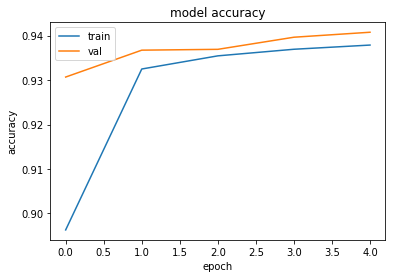

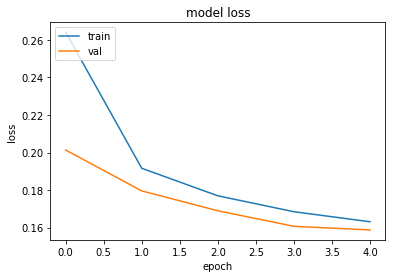

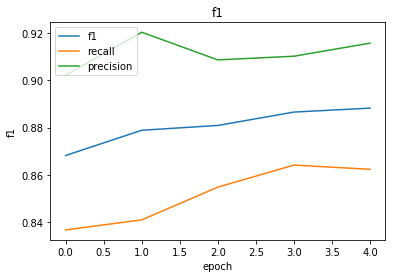

In [16]:
# summarize history for acc
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for f1, recall, precision
plt.plot(f1.val_f1s)
plt.plot(f1.val_recalls)
plt.plot(f1.val_precisions)
plt.title('f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['f1', 'recall','precision'], loc='upper left')
plt.show()

# Predict the Data

Predict the test_data_pred and if the p(xi) is over 0.5, save it as 1, otherwise 0. Predictions is the NumPy array saving the result. Formulate pd.DataFrame from df_testPred['trajectory_id'] and predictions ('target') so that the output DataFrame is in ['id', 'target'] format.

In [17]:
###################prediction for Single Traj#######################
predictions = model.predict(test_data)

predictions = (predictions >= 0.5) *1

last_test = df_test.groupby('hash').last()
t_id = pd.DataFrame(last_test['trajectory_id'])

target = pd.DataFrame(predictions)
target.columns = ['target']

output = pd.concat([t_id.reset_index(drop=True),target.reset_index(drop=True)], axis=1)
output.columns = ['id', 'target']


####################append single and multi########################


output.to_csv("Time_series_1.csv", index=False)

output

,id,target
0,traj_00032f51796fd5437b238e3a9823d13d_31_5,0
1,traj_000479418b5561ab694a2870cc04fd43_25_10,0
2,traj_000506a39775e5bca661ac80e3f466eb_29_5,1
3,traj_0005401ceddaf27a9b7f0d42ef1fbe95_1_4,0
4,traj_00063a4f6c12e1e4de7d876580620667_3_4,0
5,traj_0006535be25bb52dd06983447880c964_5_12,0
6,traj_0006f84bb33ec929d1cda7686f861d0a_31_3,1
7,traj_00093ae562586aed0e053b8431e8ace4_23_10,0
8,traj_000c739e444a70e1804d757a0580caaa_31_3,1
9,traj_000d479078af08618bddc7f09082b8c3_11_6,0
